# SIR model for Coronavirus 2019- Case China

# Import library

In [1]:
import os
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import pandas as pd
import commonFunction as cf
from tqdm import tqdm_notebook

# SIR model
* S(t) is the number of susceptible individuals. 
\begin{equation*}
\frac{dS(t)}{dt} = -\beta \frac{S(t)I(t)}{N}
\end{equation*}
* I(t) is the number of infected individuals. 
\begin{equation*}
\frac{dI(t)}{dt} = \beta \frac{S(t)I(t)}{N}-\gamma I(t)
\end{equation*}
* R(t) is the number of recovered individuals
\begin{equation*}
\frac{dR(t)}{dt} = \gamma I(t)
\end{equation*}

In [2]:
# ODEs
def SIR_model(y, t, N, beta, gamma):
    s, i, r = y
    ds_dt = -beta * s * i 
    di_dt = beta * s * i  - gamma * i
    dr_dt = gamma * i
    return ds_dt, di_dt, dr_dt

# Read Real data

In [3]:
base_path = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
df_confirmed = cf.readData(base_path, 'time_series_19-covid-Confirmed.csv','Confirmed')
df_deaths = cf.readData(base_path, 'time_series_19-covid-Deaths.csv','Deaths')
df_recovered = cf.readData(base_path, 'time_series_19-covid-Recovered.csv','Recovered')
df_confirmed = df_confirmed[df_confirmed['Country/Region']=='China']
df_deaths = df_deaths[df_deaths['Country/Region']=='China']
df_recovered = df_recovered[df_recovered['Country/Region']=='China']
df = df_confirmed.append(df_deaths)
df = df.append(df_recovered)
df = df[['Date', 'Province/State', 'Country/Region', 'Confirmed','Deaths','Recovered']]
df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].fillna(0)
df_trend = df.groupby(['Date']).sum()
df_trend['Infected'] = df_trend['Confirmed']-df_trend['Deaths']-df_trend['Recovered']

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [4]:
df_trend.tail()

,Confirmed,Deaths,Recovered,Infected
Date,,,,
2020-03-10,80887.0,3139.0,60181.0,17567.0
2020-03-11,80921.0,3161.0,61644.0,16116.0
2020-03-12,80932.0,3172.0,62901.0,14859.0
2020-03-13,80945.0,3180.0,64196.0,13569.0
2020-03-14,80977.0,3193.0,65660.0,12124.0


In [5]:
df_trend = df_trend.reset_index()
start_date = df_trend['Date'][0].strftime("%Y-%m-%d")
end_date = df_trend['Date'][len(df_trend)-1].strftime("%Y-%m-%d")

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


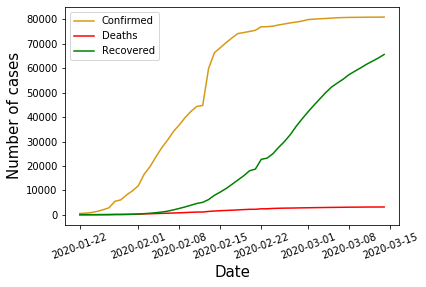

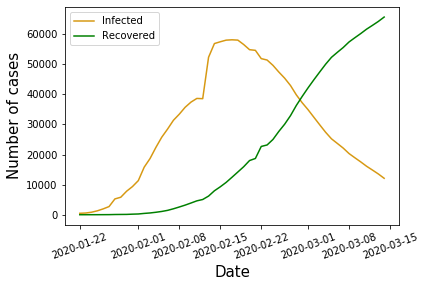

In [6]:
start = pd.Timestamp(start_date)
end = pd.Timestamp(end_date)
t = np.linspace(start.value, end.value, len(df_trend))
t = pd.to_datetime(t)
plt.plot(t, 'Confirmed', data=df_trend, color='#D79913')
plt.plot(t, 'Deaths', data=df_trend, color='red')
plt.plot(t, 'Recovered', data=df_trend, color='green')
plt.ylabel('Number of cases', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=20)
plt.legend()
plt.show()
plt.plot(t, 'Infected', data=df_trend, color='#D79913')
plt.plot(t, 'Recovered', data=df_trend, color='green')
plt.ylabel('Number of cases', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=20)
plt.legend()
plt.show()

# Parameter and initial condition
* $\beta$ is the infectious rate
* $\gamma$ is the recovery rate

In [7]:
# Total population of China
# Fractions will affect the max number of population infected.
N = 1437570976
N = N*0.56/10000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = df_trend['Infected'][0], df_trend['Recovered'][0]
S0 = N - I0 - R0
s0 = S0/N
i0 = I0/N
r0 = R0/N

In [8]:
# calculate gamma
gamma = df_trend["Recovered"][len(df_trend)-1] / sum(df_trend["Infected"])
print("Gamma: ", gamma)

Gamma:  0.04221674563285576


In [9]:
# beta
MSE = []
for beta in tqdm_notebook([i/1000 for i in range(1,1000)]):
    y0 = s0, i0, r0
    days=np.linspace(0,len(df_trend)-1,len(df_trend))
    ret = scipy.integrate.odeint(SIR_model, y0, days, args=(N, beta, gamma))
    S, I, R = ret.T * N 
    error_infected = sum(abs(df_trend['Infected']-I))
    error_recovered = sum(abs(df_trend['Recovered']-R))
    MSE.append(error_infected+error_recovered)
beta = MSE.index(min(MSE))/1000
print("Beta: ", beta)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



Beta:  0.322


# Plot graph

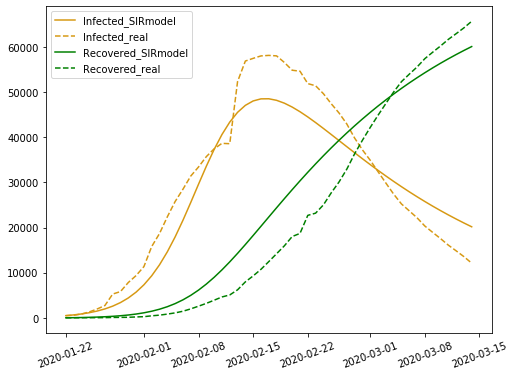

In [10]:
y0 = s0, i0, r0
days=np.linspace(0,len(df_trend)-1,len(df_trend))
ret = scipy.integrate.odeint(SIR_model, y0, days, args=(N, beta, gamma))
S, I, R = ret.T *N

# Plot for infected and Recovered
plt.figure(figsize=[8,6])
plt.plot(t, I, color='#D79913', label='Infected_SIRmodel')
plt.plot(t, 'Infected', data=df_trend, linestyle='dashed',color='#D79913',label='Infected_real')
plt.plot(t, R, color='g', label='Recovered_SIRmodel')
plt.plot(t, 'Recovered', data=df_trend, linestyle='dashed',color='g',label='Recovered_real')
plt.xticks(rotation=20)
plt.legend()
plt.show()

# Prediction

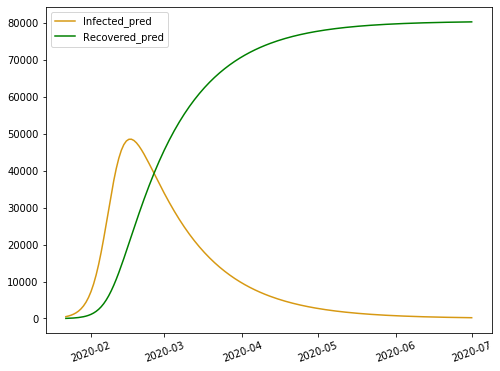

In [11]:
start = pd.Timestamp('2020-01-22')
end = pd.Timestamp('2020-7-1')
t = np.linspace(start.value, end.value, 162)
t = pd.to_datetime(t)
days = np.linspace(0,161,162)
prediction = scipy.integrate.odeint(SIR_model, y0, days, args=(N, beta, gamma))
S_p, I_p, R_p = prediction.T*N

plt.figure(figsize=[8,6])
plt.plot(t, I_p, color='#D79913', label='Infected_pred')
plt.plot(t, R_p, color='g', label='Recovered_pred')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [12]:
data = np.array([list(S_p),list(I_p),list(R_p)])
df = pd.DataFrame({"Date":t,"I":list(I_p),"R":list(R_p)})
df = df.round(0)
df.tail()

,Date,I,R
157,2020-06-27,247.0,80217.0
158,2020-06-28,237.0,80227.0
159,2020-06-29,227.0,80237.0
160,2020-06-30,218.0,80246.0
161,2020-07-01,209.0,80255.0
